## Introduction to Bayesian Power Analysis: Exclude a Null Value


Recently, I have been thinking a lot about data-driven decision-making, particularly in the context of experimentation. Why? I am uncomfortable (at all!) with the common practice of using p-values and frequentist null hypothesis significance testing to make decisions. I don't feel confident about the approach. I think it is because I do not get it. For instance, when I am forced to explain the definition of a confidence interval precisely, it does not come naturally. I always need to check with a trustworthy source (it is common to find wrong explanations online). If I do not understand it, I can not use it, especially for decision-making. I always play this exercise when thinking about business recommendations in real applications: "Would I bet my salary on this?" Whenever I work with p-values, the answer to this question is no.

There must be a better way! Of course, I am a Bayesian, but I did not want this to be a bias to try to find an answer. Frequentist hypothesis testing is so popular that there should be a reason for it. Hence, I started learning more about the topic. I started with the classic ["Statistical Decision Theory and Bayesian Analysis"](https://link.springer.com/book/10.1007/978-1-4757-4286-2) by James O. Berger. What a fantastic book! It is expensive, but it is worth every penny. The book presents solid foundations on decision theory for both frequentist and Bayesian viewpoints and aims to be agnostic about these two paradigms. Nevertheless, based on clear explanations and examples, the author can not prevent suggesting that the Bayesian approach is better for decision-making processes. I am not here to repeat the arguments, but I felt very much identified with the narrative and arguments, so I was (re-) convinced of following the Bayesian path as the framework for decision theory in practice. Of course, this was not surprising, given my Bayesian background. But I want to emphasize my intention to step back and avoid getting trapped in fanatism. 

Warning: I am not saying Bayesian methods solve everything and that frequentist methods are wrong! No, this is a much more personal statement that represents the way I think about decision-making and uncertainty. If one is not careful, Bayesian methods can fail badly. See, for example, [Is Bayesian A/B Testing Immune to Peeking? Not Exactly](http://varianceexplained.org/r/bayesian-ab-testing/) by David Robinson. With big power comes big responsibility.

Having accepted this, I immediately thought about a significant challenge. How to use Bayesian methods in organizations where frequentist approaches, p-values, and confidence intervals are the bread and butter? Trying to teach Bayesian methods in the industry is hard because of the steep learning curve and the fact that most folks out there do not see the point ("let me and my p-value do our thing"). This is not an easy problem. Ultimately, I want to use my skills to provide business value through honest decision-making; I want to bet my salary on all recommendations I give. Hence, I decided I am trying to write, for me and the community, more accessible examples about Bayesian decision theory (it is mainly for me). I am not saying there is no great material available (there is! I will mention some references below). I simply want to have something written by myself when discussing this subject with others. I had already started (unconsciously) with the simulation example ["Prior Predictive Modeling in Bayesian AB Testing"](https://juanitorduz.github.io/prior_predictive_ab_testing/) replicating the great blog ["The Bet Test: Spotting Problems in Bayesian A/B Test Analysis"](https://www.geteppo.com/blog/the-bet-test-problems-in-bayesian-ab-test-analysis) by [Tyler Buffington](https://www.geteppo.com/author/tyler-buffington) from [Eppo](https://www.geteppo.com/). They have excellent content; see, for example, ["Bayes Vs. Frequentism Can Be a Big Deal"](https://www.geteppo.com/blog/bayes-vs-frequentism-can-be-a-big-deal) by [Demetri Pananos](https://dpananos.github.io/).

I feel pretty confident about prior-predictive modeling (see, for example, ["Prior Predictive Modeling"](https://www.pymc-marketing.io/en/stable/notebooks/general/prior_predictive.html) from the [PyMC-Marketing](https://www.pymc-marketing.io/en/stable/index.html) example gallery). On the other hand, when it comes to experimentation, I have two clear gaps: Bayesian power analysis and early stopping. These are the topics I want to learn more about. In this post, we will start with the core ideas behind Bayesian power analysis. There are many great resources on this topic, such as Chapter 16 of ["Regression and Other Stories"](https://avehtari.github.io/ROS-Examples/). One reference that particular caught my mind is the paper ["The Bayesian New Statistics: Hypothesis testing, estimation, meta-analysis, and power analysis from a Bayesian perspective"](https://link.springer.com/content/pdf/10.3758/s13423-016-1221-4.pdf) by  John K. Kruschke and Torrin M. Liddell. Please read this paper (really, do it!). It is a fantastic paper describing the details and nuances of frequentist and Bayesian hypothesis testing. You can find lecture videos [here](https://doingbayesiandataanalysis.blogspot.com/2013/11/optional-stopping-in-data-collection-p.html). Similarly as before, the authors can not stop themselves from recommending Bayesian inference for decision-making. Again, I do not want to go into the arguments since these can not be better explained than in the paper.
Nevertheless, I want to highlight a remarkable fact from the manuscript: one of the recent principles by the American Statistical Association states that "Scientific conclusions and business or policy decisions should not be based only on whether a p-value passes a specific threshold. ... The widespread use of 'statistical significance' (generally interpreted as 'p < 0.05') as a license for making a claim of a scientific finding (or implied truth) leads to considerable distortion of the scientific process." Hence, I am (we!) are not alone.

Let's come back to Bayesian power analysis testing. The paper above presents a very transparent way of performing power analysis in a way I can relate and link to my previous read on decision theory. An extended and detailed description of the approach is presented in Chapter 13 of the book ["Doing Bayesian Data Analysis"](https://nyu-cdsc.github.io/learningr/assets/kruschke_bayesian_in_R.pdf) by John K. Kruschke. In this blog post, we focus on the first and simplest example presented in the book: do a power analysis for a coin-flip example when our goal is to exclude a null value. Note how the power analysis is tight to a "goal". Thus, we can have many goals like "affirm a predicted value of a parameter" or "achieve precision in the estimate of a parameter". We aim to provide complementary material to the chapter's content and reproduce the results from Table 13.1. We will do this following the schematic logic of Figure 13.1

From the hypothetical distribution of parameter values, randomly generate representative values.
From the representative parameter values, generate a random sample of data, using the planned sampling method. 
From the simulated sample of data, compute the posterior estimate, using Bayesian analysis with audience-appropriate priors.
From the posterior estimate, tally whether or not the goals were attained.
Repeat the above steps many times, to approximate the power.

We will describe each step in detail in the context of the coin-flip example.

The hope is to provide foundations to work out more complex examples in the future.

Remark: There are many ways to do Bayesian power analysis. See, for example, the approach in Max Kochurov's video [5: Bayesian AB Testing (State of Bayes Lecture Series)](https://www.youtube.com/watch?v=QllfKQH-yQ4).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import preliz as pz
import pymc as pm
from pymc.util import RandomState
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "power_sample_size"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

<Axes: >

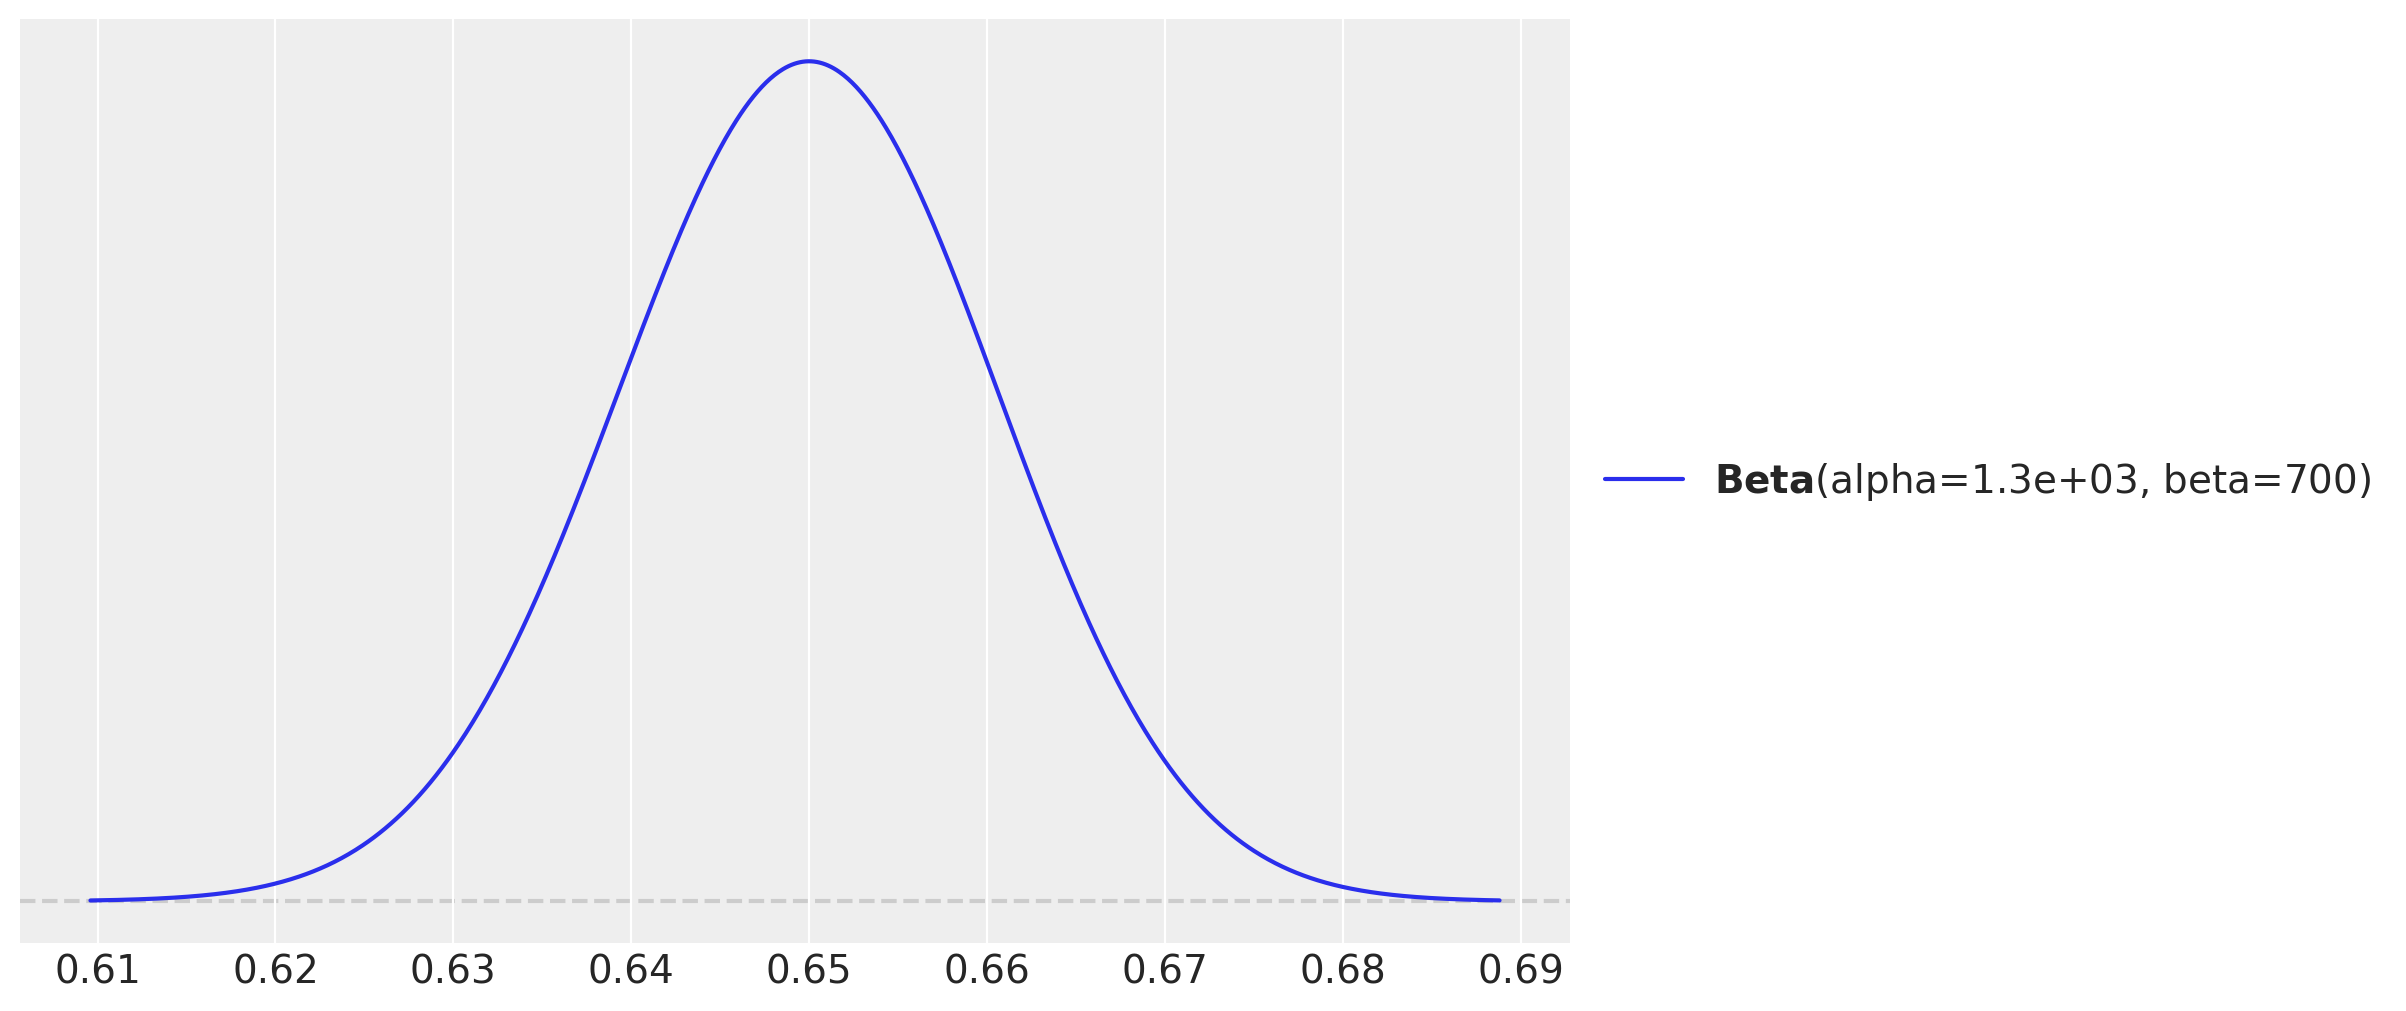

In [3]:
fig, ax = plt.subplots()
omega = 0.65
pz.Beta(alpha=omega * (2_000 - 2) + 1, beta=(1 - omega) * (2_000 - 2) + 1).plot_pdf(
    ax=ax
)


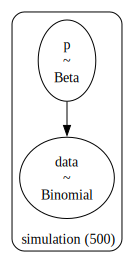

In [4]:
n_simulations = 500
n = 150

with pm.Model(coords={"simulation": range(n_simulations)}) as data_generating_model:
    omega = 0.65
    p = pm.Beta(
        "p",
        alpha=omega * (2_000 - 2) + 1,
        beta=(1 - omega) * (2_000 - 2) + 1,
        dims="simulation",
    )
    pm.Binomial("data", n=n, p=p, dims=("simulation",))

pm.model_to_graphviz(data_generating_model)


In [5]:
with data_generating_model:
    generating_model_idata = pm.sample_prior_predictive(samples=1, random_seed=rng)

generated_data = generating_model_idata["prior"]["data"].sel(chain=0, draw=0).to_numpy()

generated_data


Sampling: [data, p]


array([101,  90,  96,  96, 101,  97, 106,  98,  96, 100, 101,  94, 102,
       104,  93,  88, 113,  89,  95,  94,  88,  90,  96,  93, 101,  93,
        99,  89, 103,  98,  90,  99,  92,  93,  83,  94, 107,  91,  93,
       105,  96, 102, 102,  93,  93,  86,  93,  96, 102, 104,  90,  92,
       103, 107, 102,  90,  95, 107,  92, 102,  97,  99, 106,  98,  99,
        94, 100,  83,  99, 100, 108,  97, 108,  99,  93, 103,  99,  92,
        98, 113,  98,  96, 105,  87, 103,  96, 105,  91, 105,  94,  89,
        98,  96,  91,  99,  98,  96, 101,  91,  94,  92,  92,  94,  97,
       102, 108,  92,  95,  99,  85,  99,  99, 100,  94, 105,  95,  97,
        98,  86, 104, 101, 104,  98, 104, 101, 102,  94, 102, 102, 106,
       104,  96,  99,  98,  92, 104,  94,  92,  85,  96,  93,  88, 112,
        94, 110, 102, 102,  96,  90,  88,  91, 103, 100,  88, 102, 103,
        97,  90,  80,  93,  91,  93, 102,  96, 101,  97,  98, 101, 100,
        98,  94, 105,  95, 102, 105, 104, 100,  96,  91,  92,  9

<Axes: >

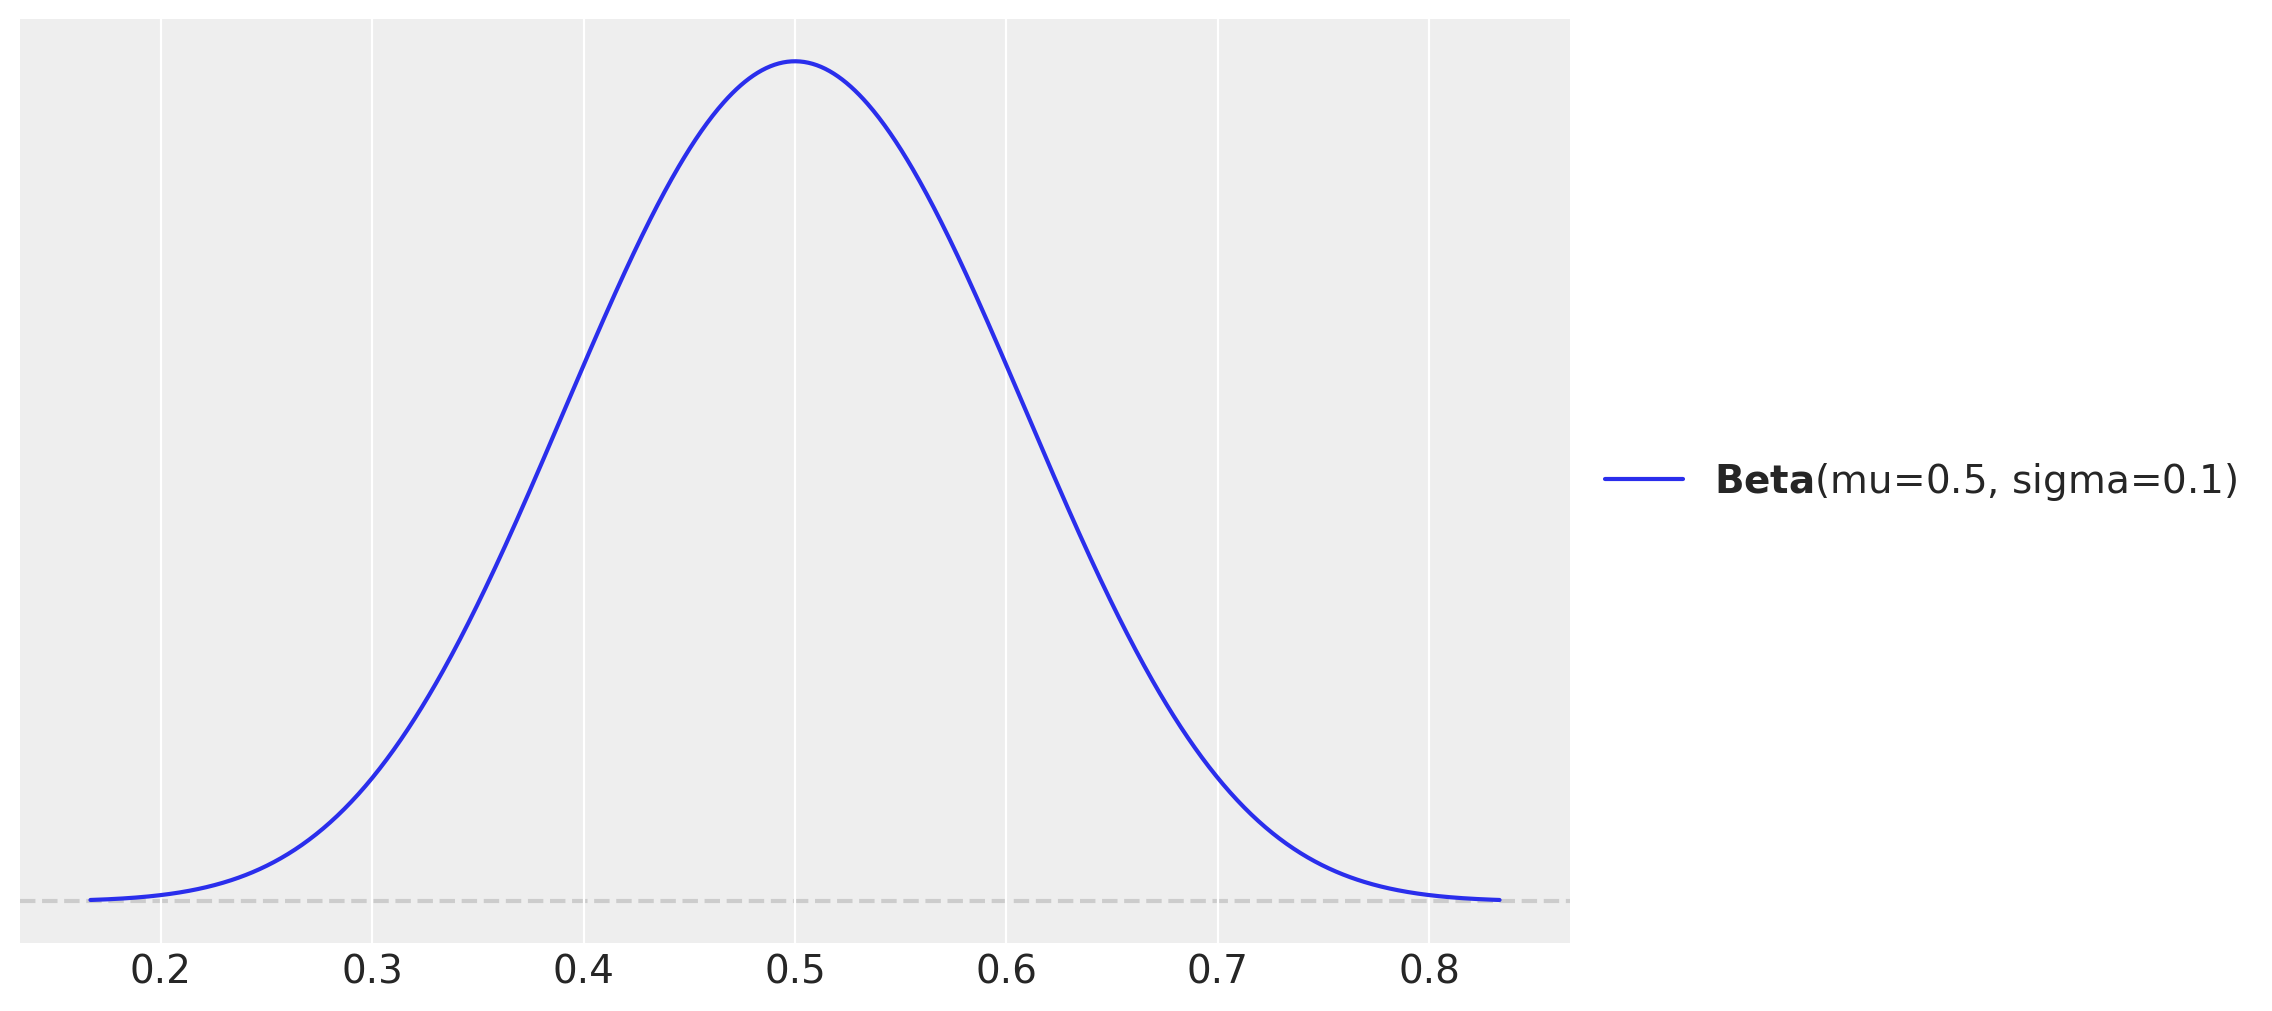

In [6]:
fig, ax = plt.subplots()
pz.Beta(mu=0.5, sigma=0.1).plot_pdf(ax=ax)

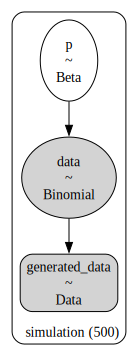

In [7]:
with pm.Model(coords={"simulation": range(n_simulations)}) as model:
    generated_data_ = pm.Data("generated_data", generated_data, dims=("simulation",))
    p = pm.Beta("p", mu=0.5, sigma=0.1, dims="simulation")
    pm.Binomial("data", n=n, p=p, observed=generated_data_, dims=("simulation",))

pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample(random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [9]:
az.summary(idata["posterior"].sel(simulation=slice(None, 10)), var_names=["p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.649,0.036,0.585,0.719,0.0,0.001,11586.0,2634.0,1.0
p[1],0.586,0.037,0.522,0.661,0.0,0.001,13071.0,2890.0,1.0
p[2],0.621,0.037,0.553,0.690,0.0,0.001,10630.0,2772.0,1.0
p[3],0.621,0.037,0.552,0.690,0.0,0.001,9460.0,2550.0,1.0
p[4],0.650,0.038,0.581,0.720,0.0,0.001,8358.0,2381.0,1.0
p[5],0.627,0.037,0.553,0.692,0.0,0.001,9505.0,2328.0,1.0
p[6],0.678,0.035,0.611,0.742,0.0,0.001,10125.0,2841.0,1.0
p[7],0.632,0.036,0.566,0.701,0.0,0.001,10597.0,2833.0,1.0
p[8],0.621,0.036,0.554,0.689,0.0,0.001,12590.0,2577.0,1.0
p[9],0.644,0.035,0.580,0.712,0.0,0.001,10177.0,2606.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

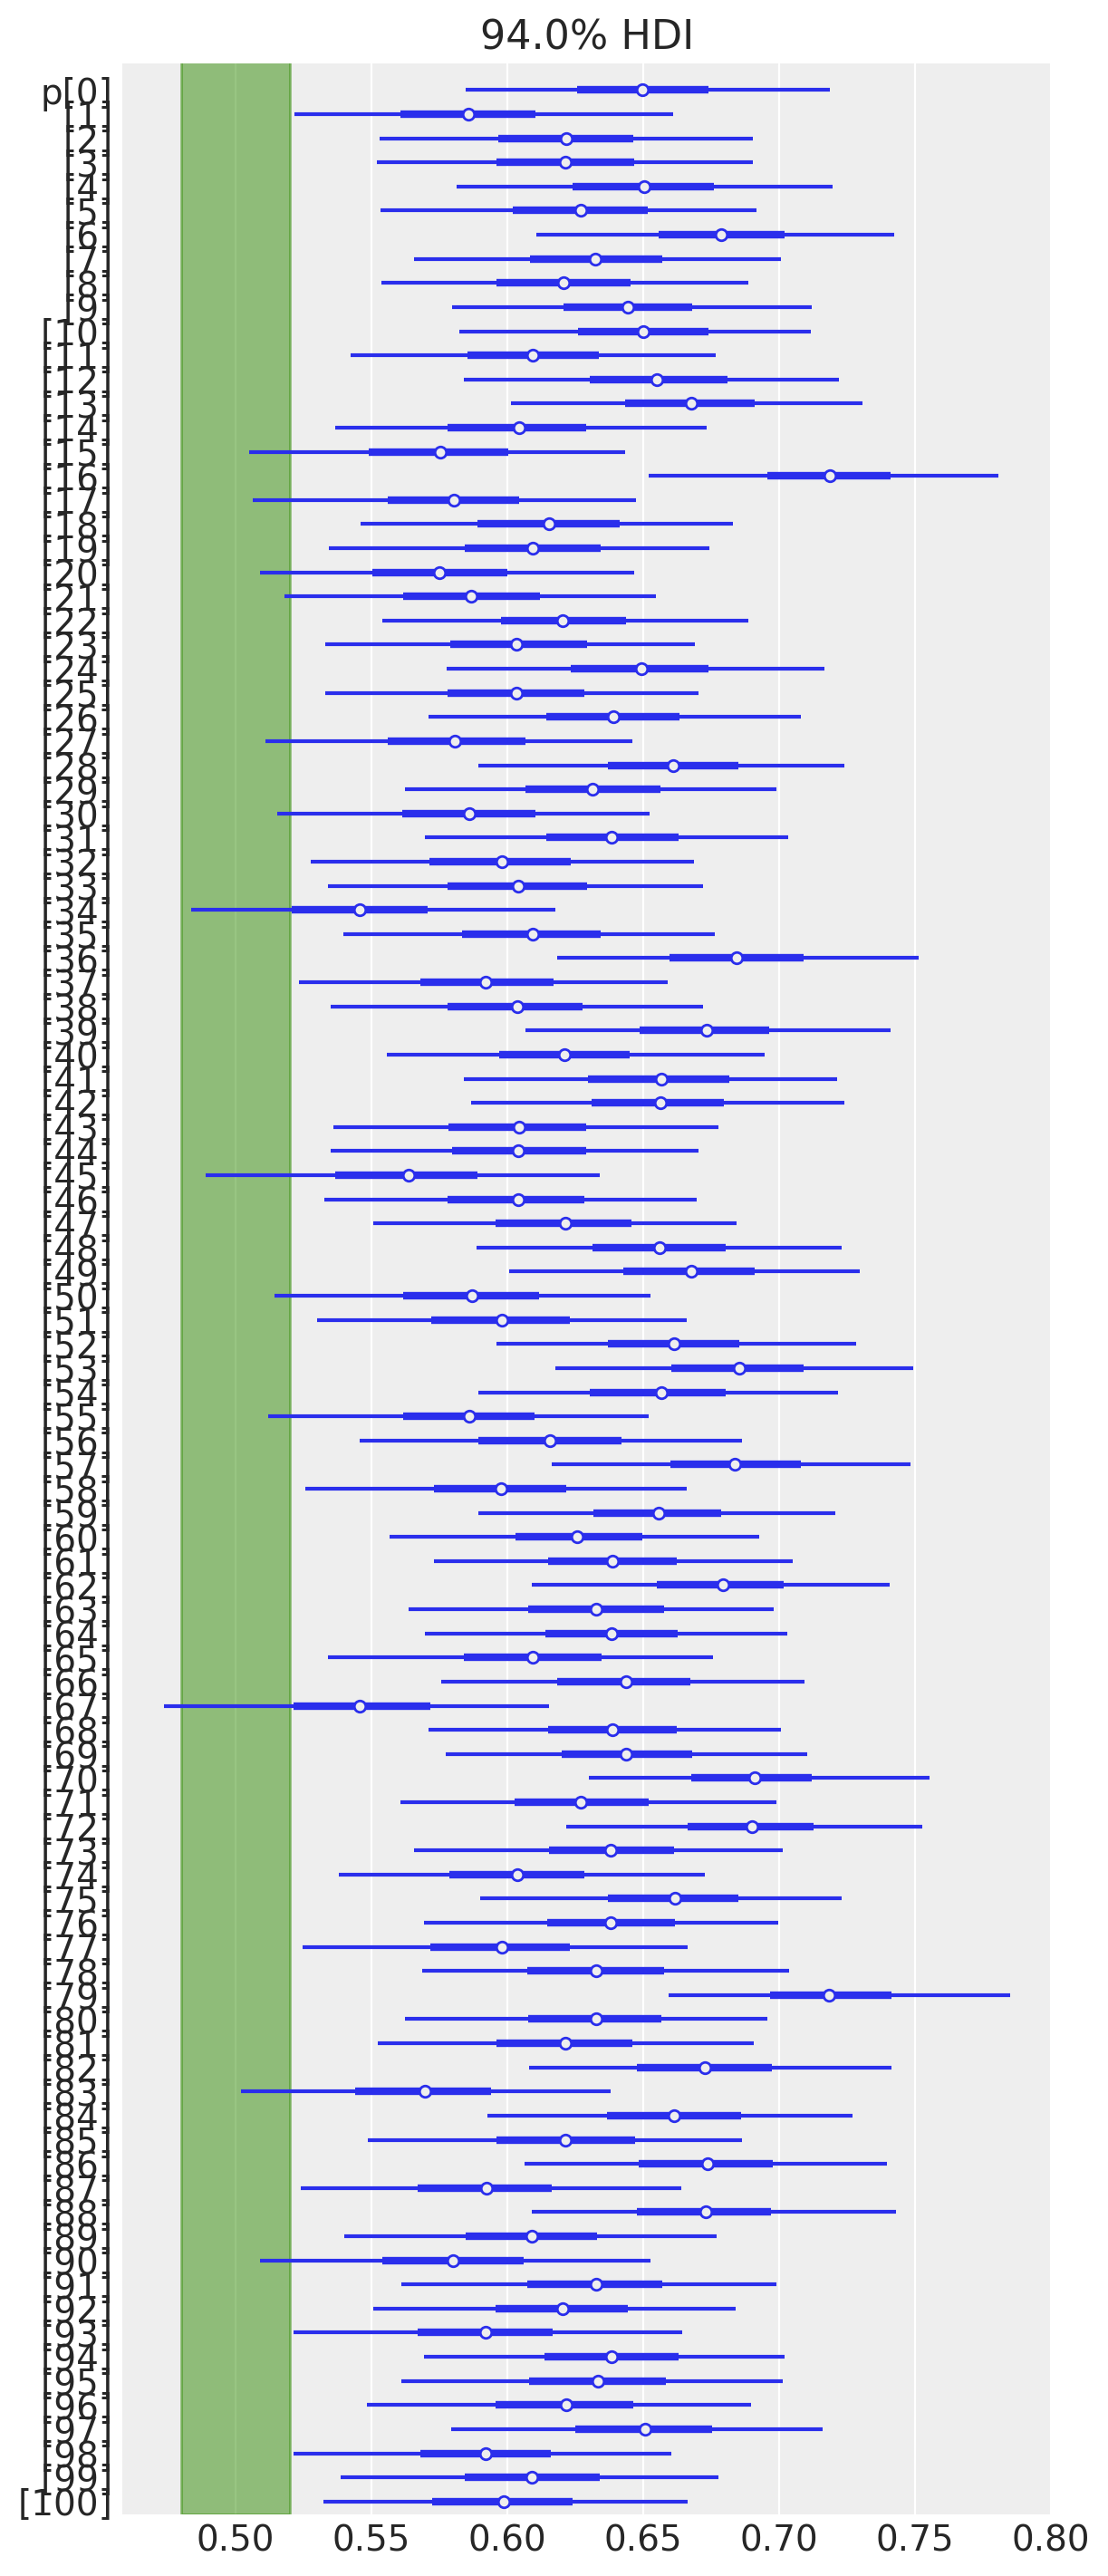

In [10]:
az.plot_forest(
    idata["posterior"].sel(simulation=slice(None, 100)),
    var_names=["p"],
    combined=True,
    rope=[0.48, 0.52],
)

In [11]:
hdi = az.hdi(idata["posterior"], hdi_prob=0.94)["p"]

rope = (0.48, 0.52)

((hdi.sel(hdi="lower") > rope[1]) | (hdi.sel(hdi="higher") < rope[0])).mean().item()

0.868

In [12]:
def generate_data(
    n_simulations: int, n: int, omega: float, random_seed: RandomState
) -> npt.NDArray:
    with pm.Model(coords={"simulation": range(n_simulations)}):
        p = pm.Beta(
            "p",
            alpha=omega * (2_000 - 2) + 1,
            beta=(1 - omega) * (2_000 - 2) + 1,
            dims="simulation",
        )
        pm.Binomial("data", n=n, p=p, dims=("simulation",))

        generating_model_idata = pm.sample_prior_predictive(
            samples=1, random_seed=random_seed
        )

    return generating_model_idata["prior"]["data"].sel(chain=0, draw=0).to_numpy()


def fit_model(
    generated_data: npt.NDArray, n_simulations: int, n: int, random_seed: RandomState
) -> az.InferenceData:
    with pm.Model(coords={"simulation": range(n_simulations)}):
        generated_data_ = pm.Data(
            "generated_data", generated_data, dims=("simulation",)
        )
        p = pm.Beta("p", mu=0.5, sigma=0.1, dims="simulation")
        pm.Binomial("data", n=n, p=p, observed=generated_data_, dims=("simulation",))

        idata = pm.sample(random_seed=random_seed, progressbar=False)
    return idata


def calculate_power(
    idata: az.InferenceData, hdi_prob: float, rope: tuple[int, int]
) -> float:
    hdi = az.hdi(idata["posterior"], hdi_prob=hdi_prob)["p"]
    condition = (hdi.sel(hdi="lower") > rope[1]) | (hdi.sel(hdi="higher") < rope[0])
    return condition.mean().item()


In [13]:
omega = 0.65
n_simulations = 500
n = 150
rope = (0.48, 0.52)
hdi_prob = 0.94


def run_power_analysis(
    n_simulations: int,
    n: int,
    omega: float,
    rope: tuple[int, int],
    hdi_prob: float,
    random_seed: RandomState,
):
    generated_data = generate_data(
        n_simulations=n_simulations, n=n, omega=omega, random_seed=random_seed
    )
    idata = fit_model(
        generated_data, n_simulations=n_simulations, n=n, random_seed=random_seed
    )
    return calculate_power(idata, hdi_prob=hdi_prob, rope=rope)


run_power_analysis(
    n_simulations=n_simulations,
    n=n,
    omega=omega,
    rope=rope,
    hdi_prob=hdi_prob,
    random_seed=rng,
)


Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


0.872

In [38]:
%%time

n_simulations = 500
rope = (0.48, 0.52)
hdi_prob = 0.94
omegas = np.linspace(0.5, 0.85, 8)
sample_sizes = np.linspace(10, 500, 20, dtype=int)

results = {}
results = {omega: [] for omega in omegas}

param_combinations = [
    (omega, sample_size) for omega in omegas for sample_size in sample_sizes
]

for omega, sample_size in tqdm(param_combinations, desc="Running power analysis"):
    power = run_power_analysis(
        n_simulations=n_simulations,
        n=sample_size,
        omega=omega,
        rope=rope,
        hdi_prob=hdi_prob,
        random_seed=rng,
    )
    results[omega].append(power)


Running power analysis:   0%|          | 0/160 [00:00<?, ?it/s]

Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4

CPU times: user 2min 51s, sys: 16.4 s, total: 3min 7s
Wall time: 5min 44s


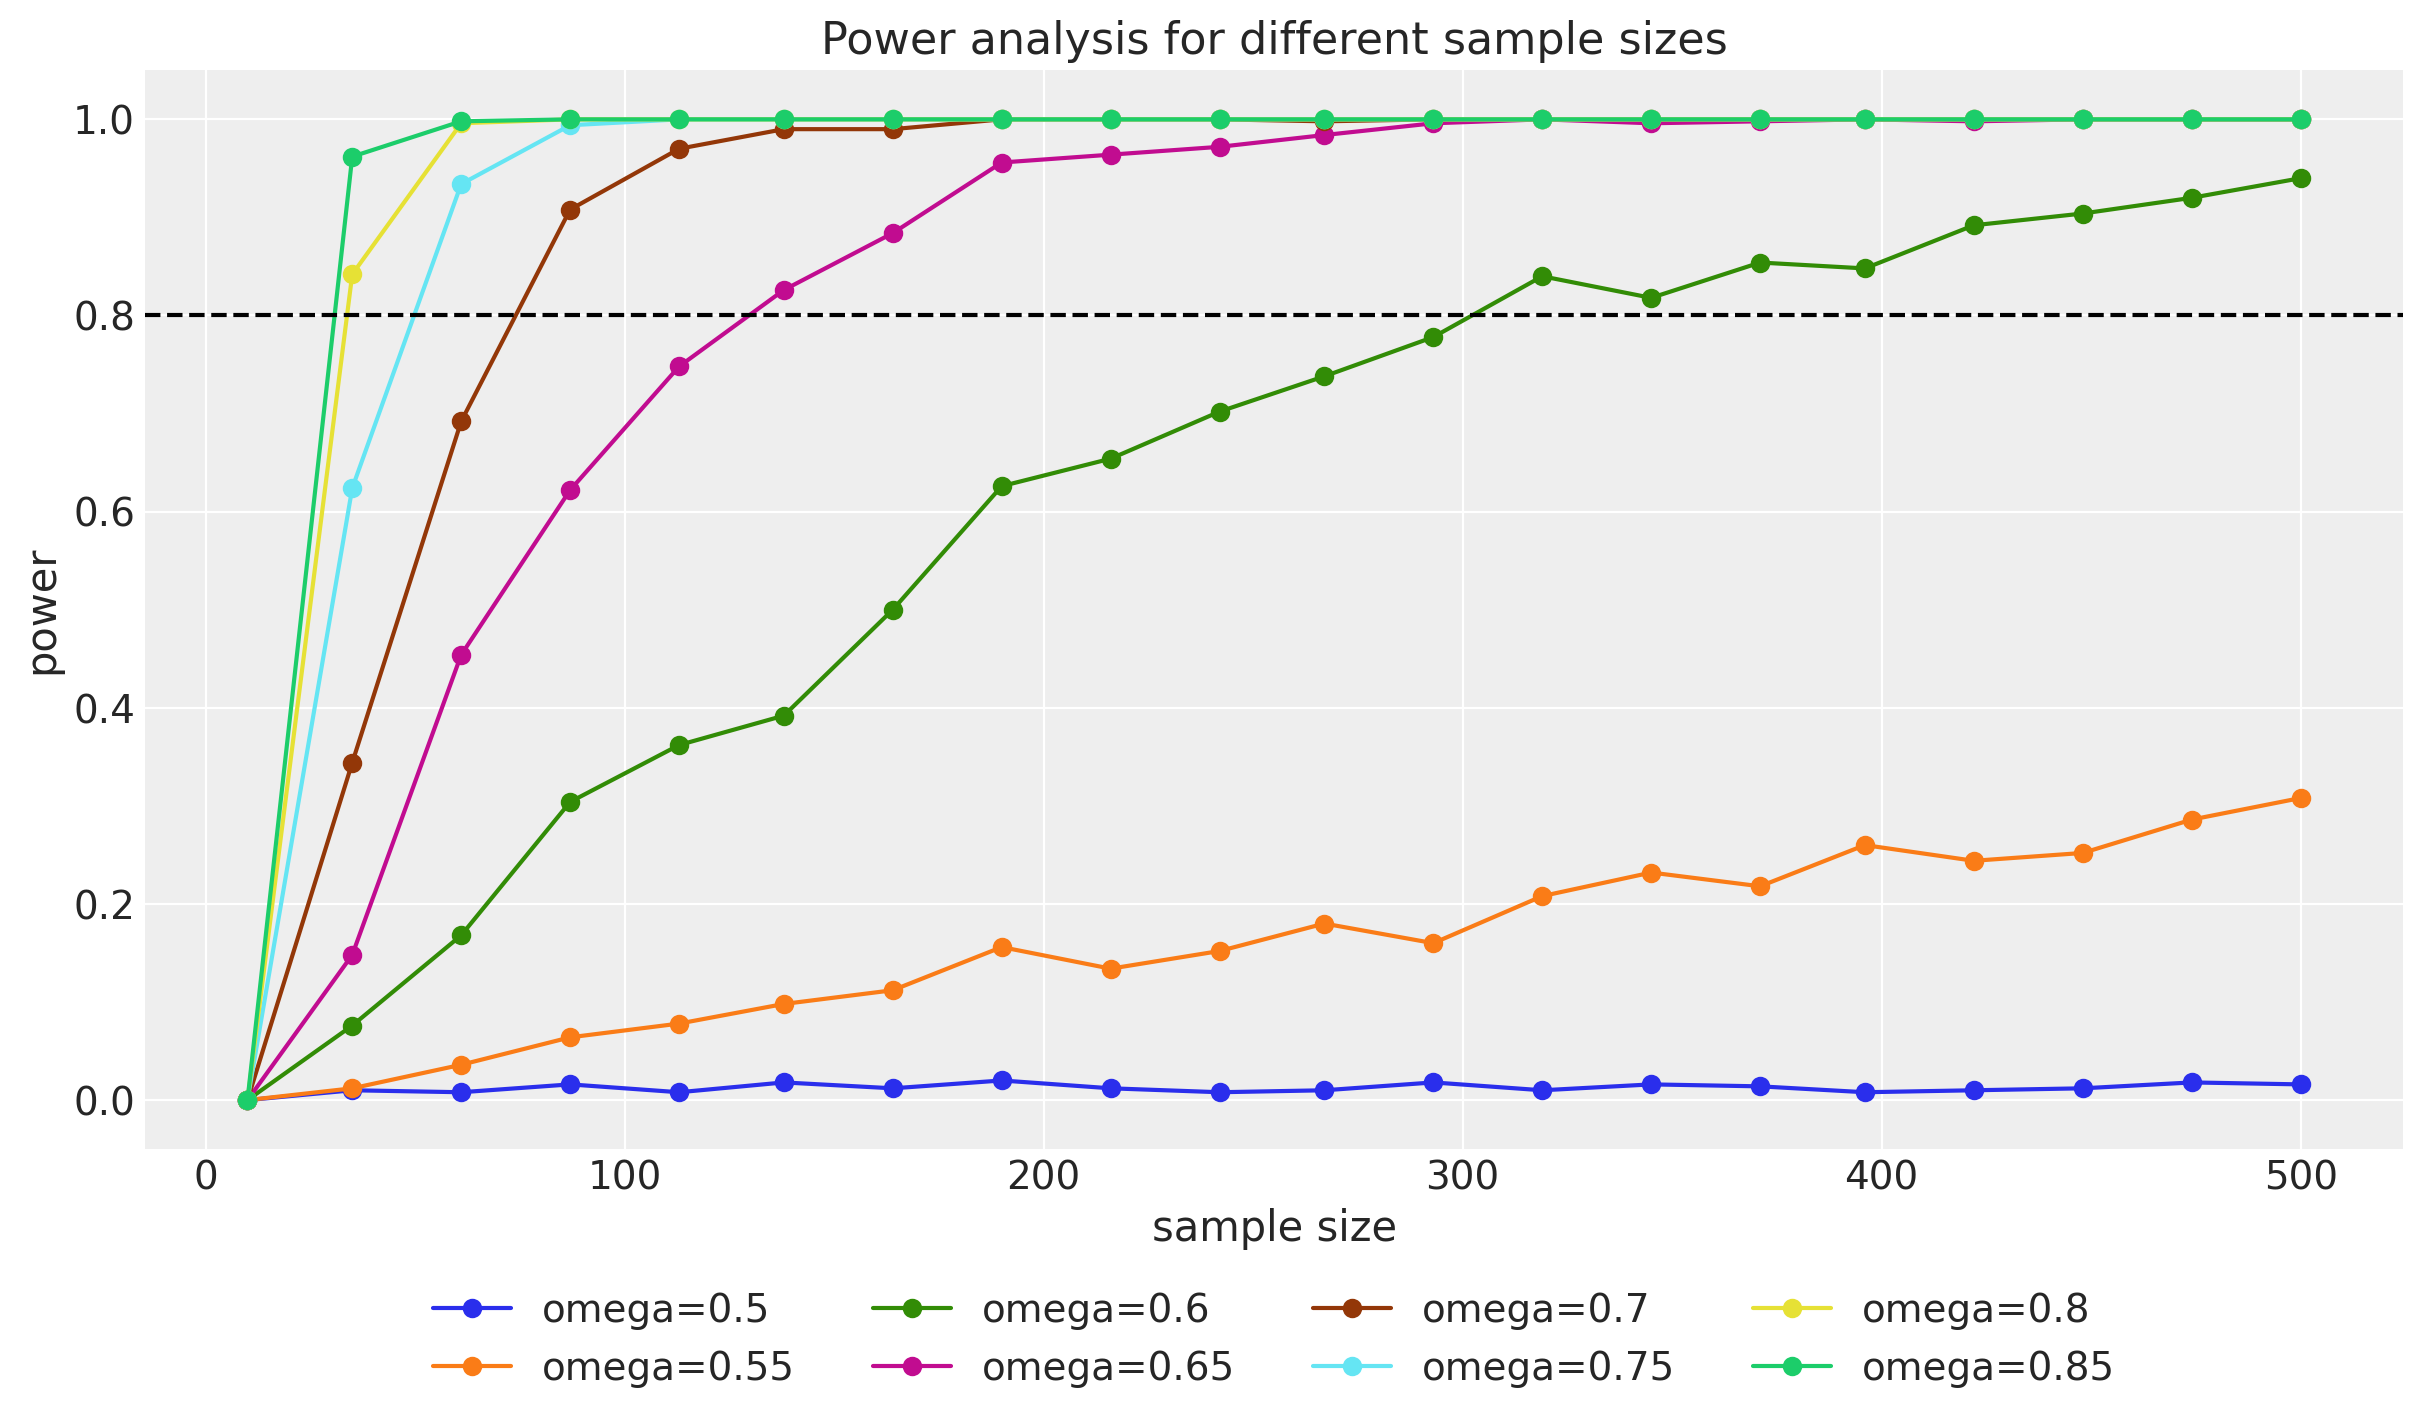

In [59]:
fig, ax = plt.subplots(figsize=(12, 7))

for i, omega in enumerate(omegas):
    ax.plot(sample_sizes, results[omega], marker="o", c=f"C{i}", label=f"omega={omega}")


ax.axhline(0.8, c="black", ls="--")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(
    title="Power analysis for different sample sizes",
    xlabel="sample size",
    ylabel="power",
);

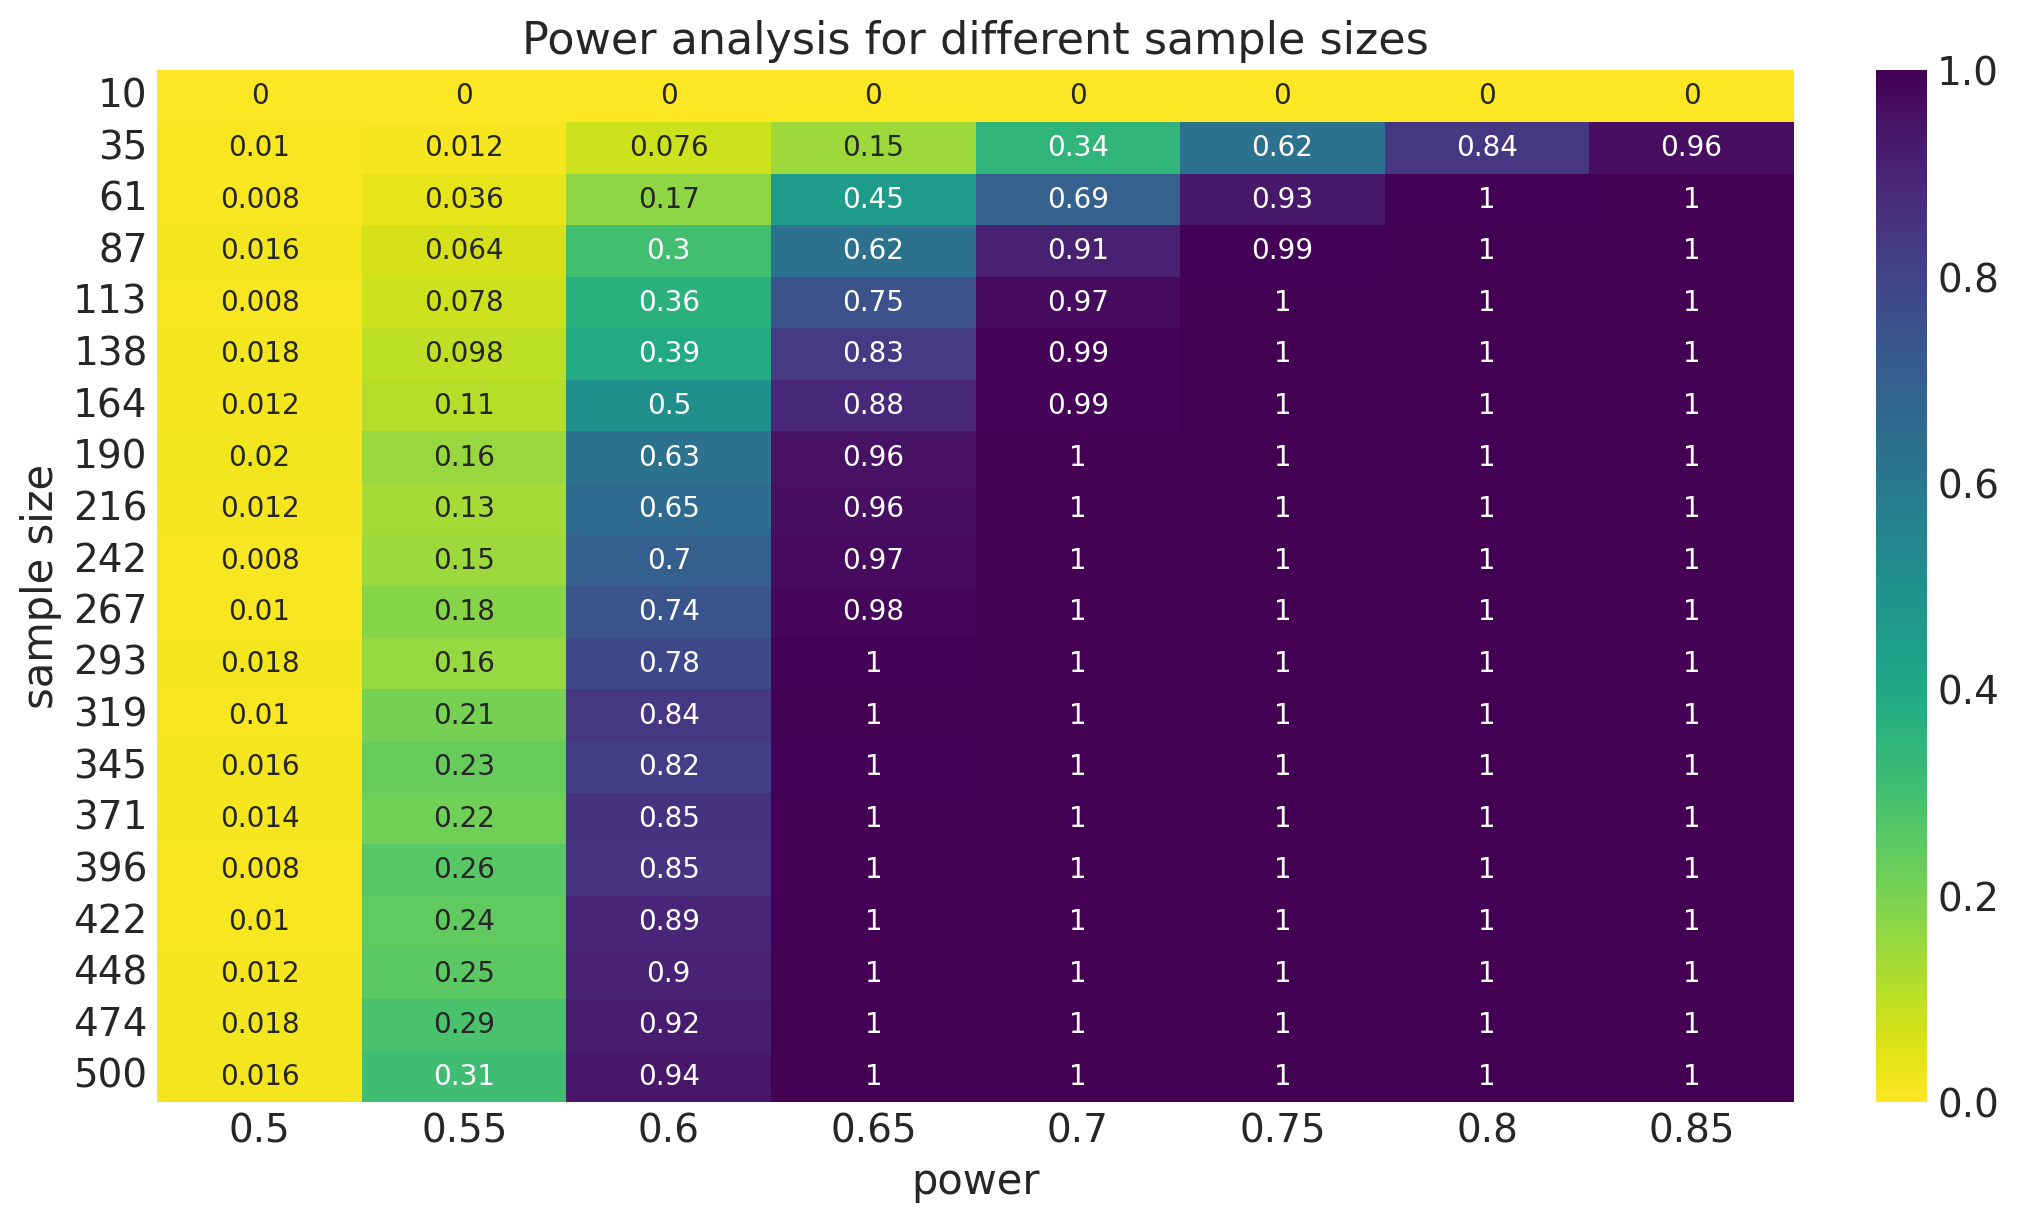

In [65]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame({"sample_size": sample_sizes, **results}).set_index(
    "sample_size"
)


fig, ax = plt.subplots()

sns.heatmap(
    data=results_df,
    annot=True,
    cmap="viridis_r",
    ax=ax,
)

ax.set(
    title="Power analysis for different sample sizes",
    xlabel="power",
    ylabel="sample size",
);